# Learning from Sequences: Timeseries and Text

Created by Dr Ana Matran-Fernandez (amatra@essex.ac.uk) for CE888 (Data Science and Decision Making)

This notebook accompanies lecture 8 and illustrates recurrent neural networks on an example of a timeseries (predicting tomorrow's temperature) and a classification problem on the IMDB text dataset.

# Imports

In [7]:
!pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4847 sha256=43f1712fe899bb39a3a746016ab443fb3ed7889cd025c65a2cb596d955efe50e
  Stored in directory: c:\users\kakoli banik\appdata\local\pip\cache\wheels\b6\0d\90\0d1bbd99855f99cb2f6c2e5ff96f8023fad8ec367695f7d72d
Successfully built termcolor


In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional, LSTM, Dense, Activation

# Timeseries

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab8/weather.csv')
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df

In [ ]:
plt.plot(range(len(df)), df['temp_avg'])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (7 years)')
plt.savefig('temperature_over_time.pdf', bbox_inches='tight')

In [ ]:
# Look at the first 2 years
length = 2*365
plt.plot(range(length), df['temp_avg'][:length])
plt.xlabel('Temporal range')
plt.ylabel('Average temperature (C) (2 years)')
plt.savefig('temperature_over_time_2y.pdf', bbox_inches='tight')

We have clear periodicity every year. In the previous plot we saw 7 cycles (7 years). Here we see 2.

Always look for periodicity in your timeseries. There will always be daily and yearly cycles. Check these patterns.

Another issue with timeseries is dividing the dataset into train/validation/test sets. We definitely cannot shuffle the data, and we need to be very careful with data leakage (using data from the future).

## Data prep

We'll try to predict the average temperature of tomorrow based on data from the past.

To avoid data leakage, we're going to use a simple approach: use the first 50% of data for training, the next 30% for validation, and the final 20% for testing.


In [ ]:
n_tr, n_val = int(0.5*len(df)), int(0.3*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

In [ ]:
# Get the data from the dataframe (dropping date column)
data = df.iloc[:, 1:].values
print(data.shape)
assert data.shape[0] == len(df)
assert data.shape[1] == len(df.columns)-1, "Are you sure you're dropping the date?"
# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data = (data - mean_tr) / std_tr


y = df['temp_avg'].values.reshape(-1, 1)

# index of the column that contains the avg_temp
y_idx = 4

In [ ]:
data[:20, y_idx] * std_tr[y_idx] + mean_tr[y_idx]

In [ ]:
y[5:25]

In [ ]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 14  # 2 weeks to predict tomorrow's temperature
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 16

In [ ]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  # first 50% for training
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  # 50%-80% for validation
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  # last 20% for test
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    #print(X[:, :, y_idx] * std_tr[y_idx] + mean_tr[y_idx])
    #print(target)
    break  # so we only print once

In [ ]:
# Function to plot history with neural networks
def plot_hist_regression(hist, y):
  n_ = len(hist.history['mae'])
  plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set')
  plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("MAE (degrees)")
  plt.axhline(y=y)
  plt.show()


## Establishing a baseline


### Common sense, no ML baseline

- Sanity check
- To establish whether ML methods are actually any good

Tomorrow's temperature is likely to be close to today's: let's predict that the temperature 24 hours from now will be equal to the temperature right now.

We'll use the MAE as metric

In [ ]:
def naive_method(dataset, mean, std):
    error = 0
    samples = 0
    count = 0
    for X, target in dataset:
        pred = X[:, -1, y_idx] * std + mean  # predict last available temperature and un-standardise
        #print(X.shape, target.shape, pred.shape)  # [batch_size, sequence_length, n_feats]
        #print(X[:, -1, y_idx] * std + mean, target)
        error += np.sum(np.abs(pred - target))
        samples += X.shape[0]  # batch_size
        count += 1
    return error / samples / batch_size # average


print('MAE on train set = %.2f (degrees Celsius)' % naive_method(train_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on validation set = %.2f (degrees Celsius)' % naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on test set = %.2f (degrees Celsius)' % naive_method(test_dataset, mean_tr[y_idx], std_tr[y_idx]))
# Save MAE on validation for later
baseline = naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx])

This baseline achieves a validation MAE of 2.69 degrees and a test MAE of 2.85 degrees. So if we assume that tomorrow's temperature will be the same as today's, we'll be off by less than 3 degrees on average.

Not too bad, but surely we can do better!

### Simple ML baseline




In [ ]:
# To get some practice with neural networks, we'll try a 1-layer NN with nothing fancy.

model_dense = models.Sequential()
model_dense.add(layers.Flatten(input_shape=(sequence_length, len(df.columns)-1)))  # we need to specify the input shape or we won't be able to see the summary
model_dense.add(layers.Dense(10, activation='relu'))
model_dense.add(layers.Dense(1))

model_dense.summary()

In [ ]:
n_epochs = 20

model_dense.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_dense = model_dense.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_dense, baseline)

Validation loss is worse than what we had with our common-sense baseline, and we're already overfitting (MAE on training set is lower than on validation set). It turns out our previous baseline is not as easy to outperform as we thought!

Remember our 'hypothesis space'? Using 2 Dense layers doesn't seem to be very useful in this case. We need other types of layers for this problem.

In [ ]:
# We know that CNNs take advantage of neighbouring values, so why don't we try that?

# In addition to the Conv2D layers we saw last week, there are Conv1D and Conv3D layers. 
# Conv1D layers rely on 1D windows that slide across an input sequence (imagine a 1D image)

model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(8, 7, activation='relu', input_shape=(sequence_length, len(df.columns)-1)))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.Conv1D(8, 3, activation='relu'))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.GlobalAveragePooling1D())
model_cnn.add(layers.Dense(1))

model_cnn.summary()

In [ ]:
model_cnn.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_cnn = model_cnn.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_cnn, baseline)

This model isn't any better, with a validation MAE of 2.77 degrees (also worse than the 'common-sense approach' that we tried at first), and we're overfitting a bit too.

Why?

In timeseries, order matters a lot: the recent past is more informative than data from 5 days ago, and convolutional layers don't take advantage of this fact -- max pooling and global average pooling layers actually destroy this order information.

## Long Short Term Memory (LSTM) Neural Networks




In [ ]:
# 1-layer LSTM

model_lstm1 = models.Sequential()
model_lstm1.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1)))
model_lstm1.add(layers.Dense(1))

model_lstm1.summary()

In [ ]:
n_epochs = 20

In [ ]:
model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm1, baseline)


In [ ]:
print('Test MAE = %.2f degrees' % model_lstm1.evaluate(test_dataset)[1])

Success! We finally beat the common-sense baseline! The validation MAE now is 2.12 degrees, and the test MAE is 2.27.

Why do LSTM layers work? Let's go back to the slides

In [ ]:
# Adding dropout

model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))
model_lstm2.add(layers.Dropout(0.4))
model_lstm2.add(layers.Dense(1))

model_lstm2.summary()

In [ ]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm2, baseline)

In [ ]:
print('Test MAE = %.2f degrees' % model_lstm2.evaluate(test_dataset)[1])

Note that validation set MAE is now lower than MAE on training set -- no longer overfitting. Validation MAE is 2.16 and test MAE is also 2.16.

NOTE: This is a very simple dataset with very small differences in performance between different models.  You'll just have to take my word for it that *in general* this approach works. 

In [ ]:
# Performance in the previous figure can (maybe) still be improved
# Let's try to add some more layers -- we can do this now that we're no longer overfitting

model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25, return_sequences=True))  # NEW!
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))  # NEW!!
model_lstm3.add(layers.Dropout(0.4))
model_lstm3.add(layers.Dense(1))
model_lstm3.summary()

In [ ]:
model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_mae', patience=2)]

history_lstm3 = model_lstm3.fit(train_dataset, epochs=60,  # increased number of epochs
                            validation_data=val_dataset,
                            callbacks=callbacks)  # but added early stopping callback


In [ ]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm3, baseline)
print('Test MAE = %.2f degrees' % model_lstm3.evaluate(test_dataset)[1])

Validation MAE = 1.92 degrees

Test MAE = 1.89 degrees


# Text

## Data prep

We'll try to predict whether the review for a movie is positive or negative looking only at the text of the review.

We'll use the IMDB text dataset for this task, which is available on `keras.datasets` and described [here](https://keras.io/api/datasets/imdb/). 

We'll merge the training and test sets and use 60% for training, 20% for validation, and 20% for testing.


As this is a binary classificationp problem, we'll use the binary cross entropy loss function. We will keep track of accuracy when training and evaluating the model.


In [3]:
def plot_hist_classif(hist):
  n_ = len(hist.history['accuracy'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Accuracy")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()


In [4]:
max_features = 15000  # only consider the top 15k words
maxlen = 500  # first 500 words of each review
batch_size = 32

print('Loading data...')
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_test), 'test sequences', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 2s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\python3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\python3\lib\site-packages\tensorflow\python\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specif

25000 train sequences (25000,)
25000 test sequences (25000,)


In [5]:
# How balanced is this dataset?
print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

0.5
0.5


In [6]:
# Merge the two datasets and divide: 60% for training, 20% validation, 20% test
x_, y_ = np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))
print(x_.shape, y_.shape)
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.4, random_state=10)  # 60/40 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)  # 50/50 split
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_val), 'validation sequences', x_val.shape)
print(len(x_test), 'test sequences', x_test.shape)

(50000,) (50000,)
30000 train sequences (30000,)
10000 validation sequences (10000,)
10000 test sequences (10000,)


In [7]:
x_train[0][:10]  # numbers!!

[1, 11531, 186, 8, 28, 6, 6482, 7, 269, 4042]

In [8]:
# We can explore what one of the reviews looks like at this point.

# Retrieve the word index file that maps words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words (which is what we have)
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

1646592/1641221 [==============================] - 0s 0us/step


"the lilly horror in one is fatale br looks meaningless in bronson be showing as you debut film ample to and ingredients zombi ample they for series and thought she's all manipulate and believing in j show look early last quote desire tight interesting that's kind out is far shelter but of frame br and"

In [9]:
# Let's ensure all sequences have the same length through padding
# - shorter reviews are padded with 0's
# - longer reviews are cut
print('Pad sequences')
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (30000, 500)
x_val shape: (10000, 500)
x_test shape: (10000, 500)


In [17]:
# Basic feedforward model
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 dense (Dense)               (None, 500, 64)           8256      
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 dense_1 (Dense)             (None, 500, 64)           4160      
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [18]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
938/938 [==============================] - 47s 50ms/step - loss: 0.4265 - accuracy: 0.7835 - val_loss: 0.2915 - val_accuracy: 0.8786
Epoch 2/20
938/938 [==============================] - 47s 50ms/step - loss: 0.2425 - accuracy: 0.9045 - val_loss: 0.2745 - val_accuracy: 0.8906
Epoch 3/20
938/938 [==============================] - 43s 46ms/step - loss: 0.2094 - accuracy: 0.9201 - val_loss: 0.2646 - val_accuracy: 0.8975
Epoch 4/20
938/938 [==============================] - 43s 46ms/step - loss: 0.1903 - accuracy: 0.9269 - val_loss: 0.2773 - val_accuracy: 0.8933
Epoch 5/20
600/938 [==================>...........] - ETA: 14s - loss: 0.1749 - accuracy: 0.9331

KeyboardInterrupt: 

In [ ]:
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])  # overfitting!

In [ ]:
# Let's try an RNN
model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
# This model will take a long time to train, so we add an early stopping criterion
# N.B: It's actually much faster to train WITHOUT A GPU!!
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])
# Note that we're still overfitting, but this is just an example of use

## Your turn!

Implement a bidirectional RNN that can outperform the LSTM model we had above.

A starting skeleton could be:
 
*   Embedding layer with an output dimension of 64
*   Bidirectional layer with a 32-neuron LSTM layer
*   Dense layer with 1 neuron and a sigmoid activation

Some suggestions:

- Change the sizes of the layers (i.e., the numbers of neurons)
- Add dropout
- Add other recurrent and/or bidirectional layers

Once you have a model that scores over 90% on the validation set, check its performance on the test set and upload it on the code checker in Moodle.

Note that the model I'm suggesting above will be able to reach the desired performance, but it will show signs of overfitting. Can you do it by adding regularization (dropout, smaller network) so you don't overfit?


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          960000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 984,897
Trainable params: 984,897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/7
938/938 [==============================] - 109s 113ms/step - loss: 0.4753 - accuracy: 0.7589 - val_loss: 0.2785 - val_accuracy: 0.8873
Epoch 2/7
938/938 [==============================] - 107s 114ms/step - loss: 0.2534 - accuracy: 

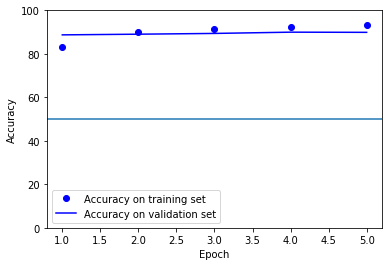

313/313 [==============================] - 8s 26ms/step - loss: 0.2600 - accuracy: 0.8988
Test Accuracy = 0.90


In [13]:
n_ = 7  # number of epochs. You can edit this

model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# I DON'T RECOMMEND THAT YOU CHANGE CODE AFTER THIS POINT
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())

# This model will take a long time to train, so we add an early stopping criterion
# I've also added a ModelCheckpoint that will save the best model according to val_accuracy regardless of whether we continue training
callbacks = [EarlyStopping(monitor='val_accuracy', patience=1),
             ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", mode='max')]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)
plot_hist_classif(history)
model = keras.models.load_model("model.keras")
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          960000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 195       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 4         
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 985,031
Trainable params: 985,031
Non-trainable params: 0
________________________________________________

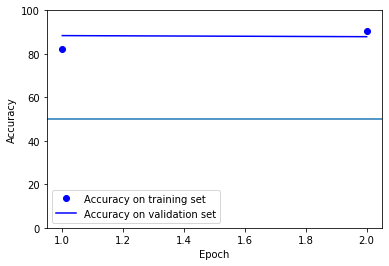

313/313 [==============================] - 9s 29ms/step - loss: 0.2808 - accuracy: 0.8873
Test Accuracy = 0.89


In [20]:
n_ = 10  # number of epochs. You can edit this

model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.5))
model.add(Dense(3))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# I DON'T RECOMMEND THAT YOU CHANGE CODE AFTER THIS POINT
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

print(model.summary())

# This model will take a long time to train, so we add an early stopping criterion
# I've also added a ModelCheckpoint that will save the best model according to val_accuracy regardless of whether we continue training
callbacks = [EarlyStopping(monitor='val_accuracy', patience=1),
             ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", mode='max')]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)
plot_hist_classif(history)
model = keras.models.load_model("model.keras")
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])

In [19]:
if model.count_params() > 1000000:
    print("Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.")

if history.history["val_accuracy"][-1] > 0.9:
    print("Your model is accurate enough!")

else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")
# Save the model into a local folder
keras.models.save_model(model, "Model.h5",save_format='h5')
print('Model saved! You can now upload it to the lab quiz.')

Accuracy is below the threshold!


Exception: Your model isn't accurate enough to pass the progress checker!